In [9]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from iexfinance.refdata import get_symbols
from iexfinance.account import get_metadata
from iexfinance.stocks import get_historical_data

mpl.rcParams['figure.figsize'] = (16, 9)

In [10]:
iex_token = os.environ['IEX_TOKEN']
if iex_token is None:
    raise Exception("IEX_TOKEN should be set")
get_metadata()

,metadata
circuitBreaker,0
effectiveDate,None
messageLimit,5000000
messagesUsed,112031
payAsYouGoEnabled,False
subscriptionTermType,annual
tierName,launch


In [135]:
def create_df(csv_path, symbols, start, end, overwrite=False):
    if not overwrite and os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        df['date'] = pd.to_datetime(df['date'])
        return df.set_index('date')
    else:
        df = get_historical_data(symbols, start, end)
        df.columns = df.columns.to_flat_index().map(lambda tup: f'{tup[0]}_{tup[1]}')
        df.to_csv(csv_path)
        return create_df(csv_path, symbols, start, end)

In [136]:
csv_path='stonk.csv'
symbols = ['TSLA', 'SPY', 'TQQQ', 'FNGU', 'AAPL', 'AMD']
start = datetime.datetime(2015, 9, 4)
end = datetime.datetime(2020, 9, 4)
df = create_df(csv_path, symbols, start, end, overwrite=False)

# test_df = get_historical_data(symbols, start, end)

In [137]:
df.head()

,TSLA_open,TSLA_high,TSLA_low,TSLA_close,TSLA_volume,SPY_open,SPY_high,SPY_low,SPY_close,SPY_volume,...,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_volume,AMD_open,AMD_high,AMD_low,AMD_close,AMD_volume
date,,,,,,,,,,,,,,,,,,,,,
2015-09-08,49.01,49.83,48.81,49.63,15691155,195.94,197.61,195.17,197.43,116025739,...,27.91,28.14,27.58,28.08,219374520,1.85,1.88,1.83,1.88,6009499
2015-09-09,50.41,50.85,49.66,49.78,16953940,199.32,199.47,194.35,194.79,149347735,...,28.44,28.51,27.44,27.54,340043216,1.90,1.97,1.83,1.85,12612253
2015-09-10,49.45,50.14,49.07,49.70,13545120,194.56,197.22,194.25,195.85,158611063,...,27.57,28.32,27.48,28.14,251571324,1.84,1.88,1.83,1.84,4290423
2015-09-11,49.53,50.05,48.95,50.05,11754220,195.38,196.82,194.53,196.74,119691212,...,27.95,28.55,27.94,28.55,199661892,1.88,2.14,1.81,2.01,31010289
2015-09-14,50.22,50.85,49.93,50.64,14454255,196.95,197.01,195.43,196.01,79451983,...,29.15,29.22,28.72,28.83,233453724,2.00,2.00,1.81,1.82,16458540


In [138]:
df.tail()

,TSLA_open,TSLA_high,TSLA_low,TSLA_close,TSLA_volume,SPY_open,SPY_high,SPY_low,SPY_close,SPY_volume,...,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_volume,AMD_open,AMD_high,AMD_low,AMD_close,AMD_volume
date,,,,,,,,,,,,,,,,,,,,,
2020-08-31,444.61,500.14,440.11,498.32,118374406,350.35,351.30,349.06,349.31,66099183,...,127.58,131.00,126.00,129.04,225702688,85.05,92.64,85.05,90.82,90655945
2020-09-01,502.14,502.49,470.51,475.05,90119419,350.21,352.71,349.24,352.60,54999325,...,132.76,134.80,130.53,134.18,152470142,91.92,92.51,90.19,92.18,56117100
2020-09-02,478.99,479.04,405.12,447.37,96176128,354.67,358.75,353.43,357.70,69540035,...,137.59,137.98,127.00,131.40,200118991,94.01,94.28,88.74,90.22,50366918
2020-09-03,407.23,431.80,402.00,407.00,87596086,355.87,356.38,342.59,345.39,148011129,...,126.91,128.84,120.50,120.88,257599640,87.84,88.47,81.59,82.54,87462687
2020-09-04,402.81,428.00,372.02,418.32,110321885,346.13,347.83,334.87,342.57,139156281,...,120.07,123.70,110.89,120.96,332607163,81.45,84.39,76.33,82.01,82267760


In [139]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TSLA_open,1259.0,7.417242e+01,6.075877e+01,28.46,4.587000e+01,5.935000e+01,6.903500e+01,5.021400e+02
TSLA_high,1259.0,7.582474e+01,6.300772e+01,30.99,4.648500e+01,6.020000e+01,7.000000e+01,5.024900e+02
TSLA_low,1259.0,7.246597e+01,5.836644e+01,28.21,4.511000e+01,5.791000e+01,6.784500e+01,4.705100e+02
TSLA_close,1259.0,7.424546e+01,6.098155e+01,28.73,4.592500e+01,5.908000e+01,6.902000e+01,4.983200e+02
TSLA_volume,1259.0,4.175065e+07,3.053411e+07,3551385.00,2.211148e+07,3.235852e+07,4.987730e+07,3.046938e+08
SPY_open,1259.0,2.586829e+02,3.916023e+01,182.34,2.213700e+02,2.639700e+02,2.877450e+02,3.558700e+02
SPY_high,1259.0,2.600081e+02,3.935610e+01,184.10,2.217800e+02,2.660500e+02,2.891400e+02,3.587500e+02
SPY_low,1259.0,2.572344e+02,3.888204e+01,181.02,2.205400e+02,2.622000e+02,2.859100e+02,3.534300e+02
SPY_close,1259.0,2.587344e+02,3.912420e+01,182.86,2.216100e+02,2.639300e+02,2.878200e+02,3.577000e+02
SPY_volume,1259.0,9.186399e+07,5.024659e+07,20270007.00,5.895775e+07,7.761794e+07,1.065249e+08,3.922207e+08


FNGU only has 661 samples, going to drop for now

In [141]:
df = df.drop([col for col in df.columns if col[:4] == "FNGU"], axis=1)

In [151]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TSLA_open,1259.0,7.417242e+01,6.075877e+01,2.846000e+01,4.587000e+01,5.935000e+01,6.903500e+01,5.021400e+02
TSLA_high,1259.0,7.582474e+01,6.300772e+01,3.099000e+01,4.648500e+01,6.020000e+01,7.000000e+01,5.024900e+02
TSLA_low,1259.0,7.246597e+01,5.836644e+01,2.821000e+01,4.511000e+01,5.791000e+01,6.784500e+01,4.705100e+02
TSLA_close,1259.0,7.424546e+01,6.098155e+01,2.873000e+01,4.592500e+01,5.908000e+01,6.902000e+01,4.983200e+02
TSLA_volume,1259.0,4.175065e+07,3.053411e+07,3.551385e+06,2.211148e+07,3.235852e+07,4.987730e+07,3.046938e+08
SPY_open,1259.0,2.586829e+02,3.916023e+01,1.823400e+02,2.213700e+02,2.639700e+02,2.877450e+02,3.558700e+02
SPY_high,1259.0,2.600081e+02,3.935610e+01,1.841000e+02,2.217800e+02,2.660500e+02,2.891400e+02,3.587500e+02
SPY_low,1259.0,2.572344e+02,3.888204e+01,1.810200e+02,2.205400e+02,2.622000e+02,2.859100e+02,3.534300e+02
SPY_close,1259.0,2.587344e+02,3.912420e+01,1.828600e+02,2.216100e+02,2.639300e+02,2.878200e+02,3.577000e+02
SPY_volume,1259.0,9.186399e+07,5.024659e+07,2.027001e+07,5.895775e+07,7.761794e+07,1.065249e+08,3.922207e+08


array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

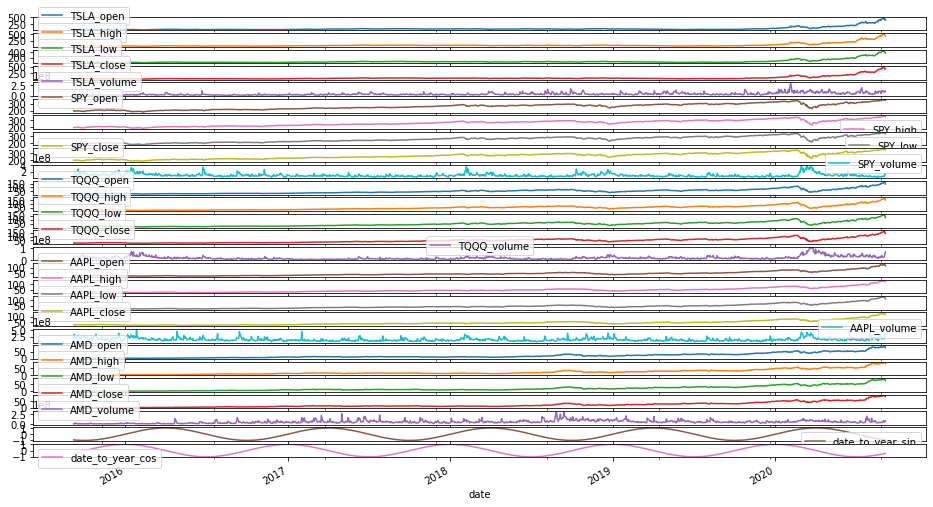

In [152]:
df.plot(subplots=True)

### Feature Engineering

#### Time

We want to account for seasonality in prices. We can map our `date` index feature datetimes into useable signals using sin and cos.

In [153]:
index_timestamp_seconds = np.array(df.index.map(datetime.datetime.timestamp))
index_timestamp_seconds

array([1.4416848e+09, 1.4417712e+09, 1.4418576e+09, ..., 1.5990192e+09,
       1.5991056e+09, 1.5991920e+09])

In [154]:
seconds_per_day = 24 * 60 * 60
seconds_per_year = 365.2425 * seconds_per_day
date_to_year_sin = np.sin(index_timestamp_seconds * (2 * np.pi / seconds_per_year))
date_to_year_cos = np.cos(index_timestamp_seconds * (2 * np.pi / seconds_per_year))

Text(0.5, 1.0, 'Time of year signal')

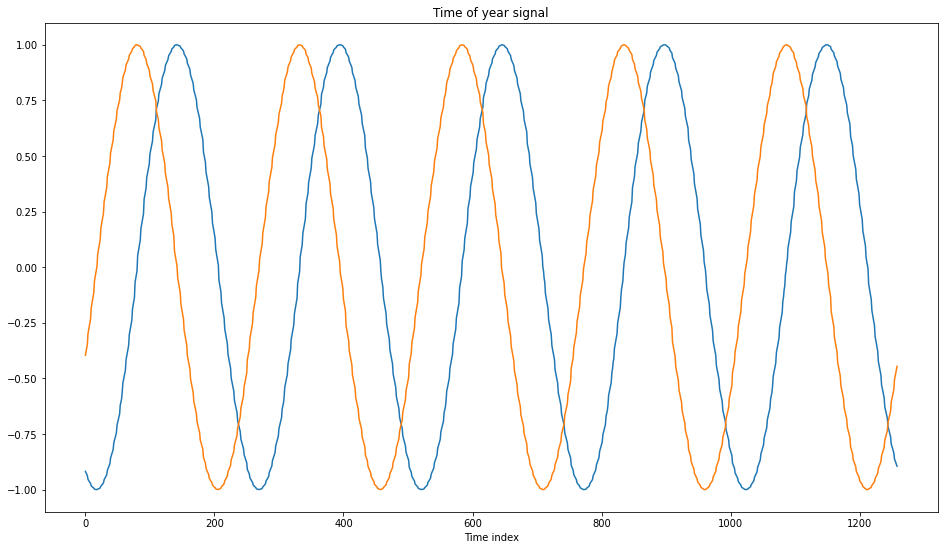

In [155]:
plt.plot(np.array(date_to_year_sin))
plt.plot(np.array(date_to_year_cos))
plt.xlabel('Time index')
plt.title('Time of year signal')

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

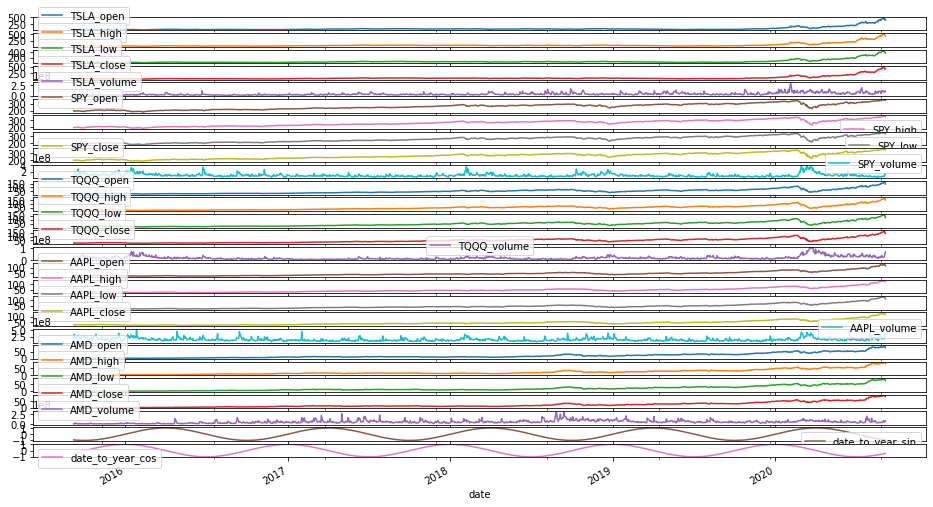

In [156]:
df['date_to_year_sin'] = date_to_year_sin
df['date_to_year_cos'] = date_to_year_cos
df.plot(subplots=True)

### Split the data

In [157]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

In [158]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

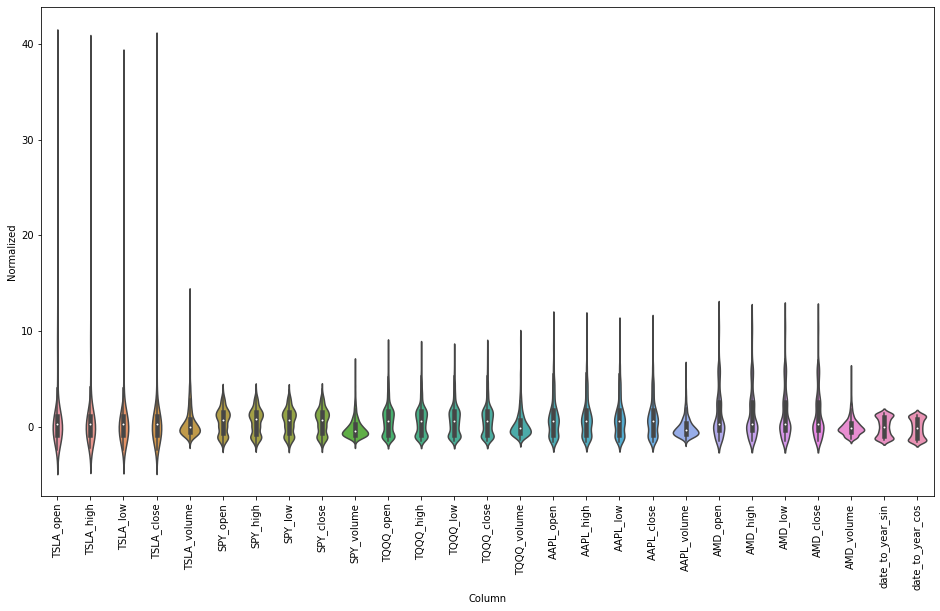

In [159]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure()
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

### Data windowing

In [170]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col='TSLA_close', max_subplots=3):
        inputs, labels = self.example
        plt.figure()
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [date]')
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [208]:
label_columns=['TSLA_close']
w1 = WindowGenerator(input_width=30, label_width=1, shift=1,
                     label_columns=label_columns)
w1

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['TSLA_close']

In [209]:
w2 = WindowGenerator(input_width=7, label_width=1, shift=1,
                     label_columns=label_columns)
w2

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['TSLA_close']

In [210]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 8, 27)
Inputs shape: (3, 7, 27)
labels shape: (3, 1, 1)


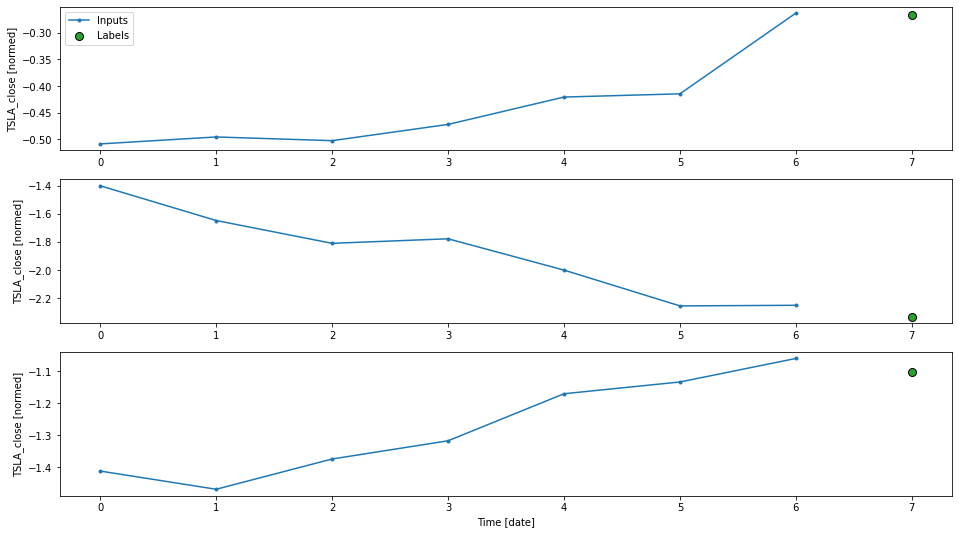

In [211]:
w2._example = example_inputs, example_labels
w2.plot()

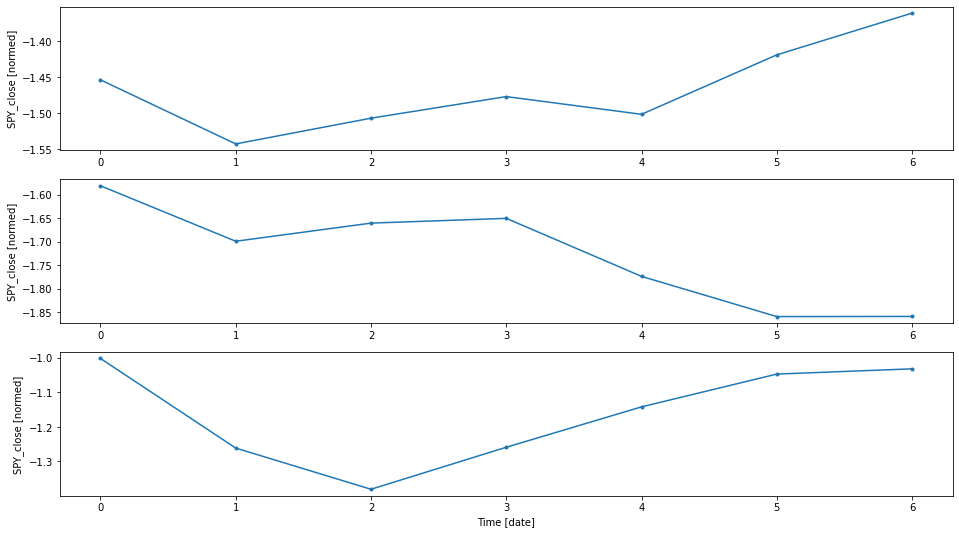

In [212]:
w2.plot(plot_col='SPY_close')

In [213]:
w2.train.element_spec

(TensorSpec(shape=(None, 7, 27), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [214]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 7, 27)
Labels shape (batch, time, features): (32, 1, 1)


### Single step models

In [215]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=label_columns)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['TSLA_close']

In [216]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 27)
Labels shape (batch, time, features): (32, 1, 1)


#### baseline model

Need something simple to compare more complex models against

In [217]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [218]:
baseline = Baseline(label_index=column_indices['TSLA_close'])
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

8/8 [==============================] - 0s 629us/step - loss: 0.1406 - mean_absolute_error: 0.1758


In [219]:
wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1,
    label_columns=label_columns)

wide_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): ['TSLA_close']

In [220]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 27)
Output shape: (32, 1, 1)


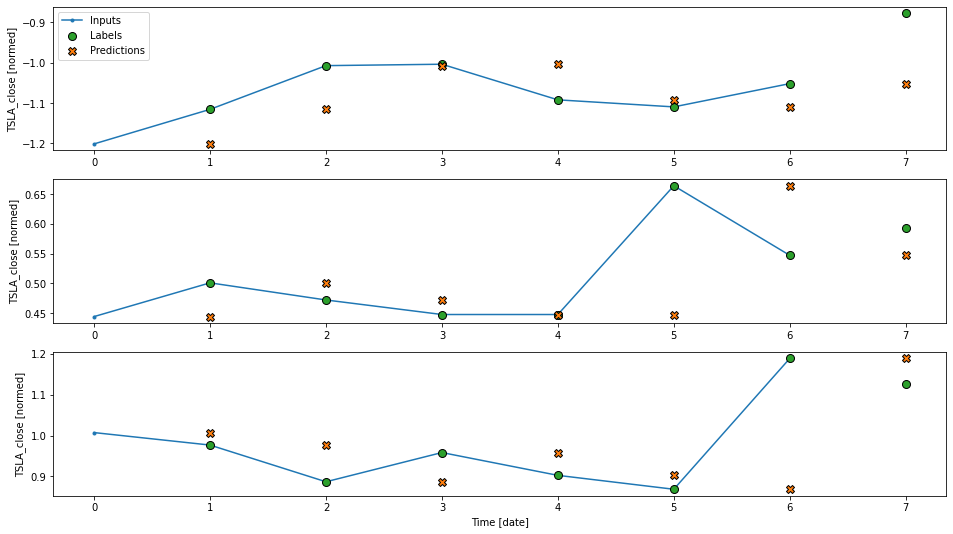

In [221]:
wide_window.plot(baseline)

In [222]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [223]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 27)
Output shape: (32, 1, 1)


In [224]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [225]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
28/28 [==============================] - 0s 6ms/step - loss: 1.7321 - mean_absolute_error: 1.0022 - val_loss: 13.7300 - val_mean_absolute_error: 2.8857
Epoch 2/20
28/28 [==============================] - 0s 3ms/step - loss: 1.2499 - mean_absolute_error: 0.8730 - val_loss: 13.4381 - val_mean_absolute_error: 2.5707
Epoch 3/20
28/28 [==============================] - 0s 3ms/step - loss: 1.0211 - mean_absolute_error: 0.8063 - val_loss: 11.7116 - val_mean_absolute_error: 2.2880
Epoch 4/20
28/28 [==============================] - 0s 4ms/step - loss: 0.8637 - mean_absolute_error: 0.7471 - val_loss: 10.0985 - val_mean_absolute_error: 2.0509
Epoch 5/20
28/28 [==============================] - 0s 3ms/step - loss: 0.7383 - mean_absolute_error: 0.6935 - val_loss: 8.4390 - val_mean_absolute_error: 1.8383
Epoch 6/20
28/28 [==============================] - 0s 3ms/step - loss: 0.6347 - mean_absolute_error: 0.6424 - val_loss: 6.9784 - val_mean_absolute_error: 1.6469
Epoch 7/20
28/28 [======

In [226]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 7, 27)
Output shape: (32, 7, 1)


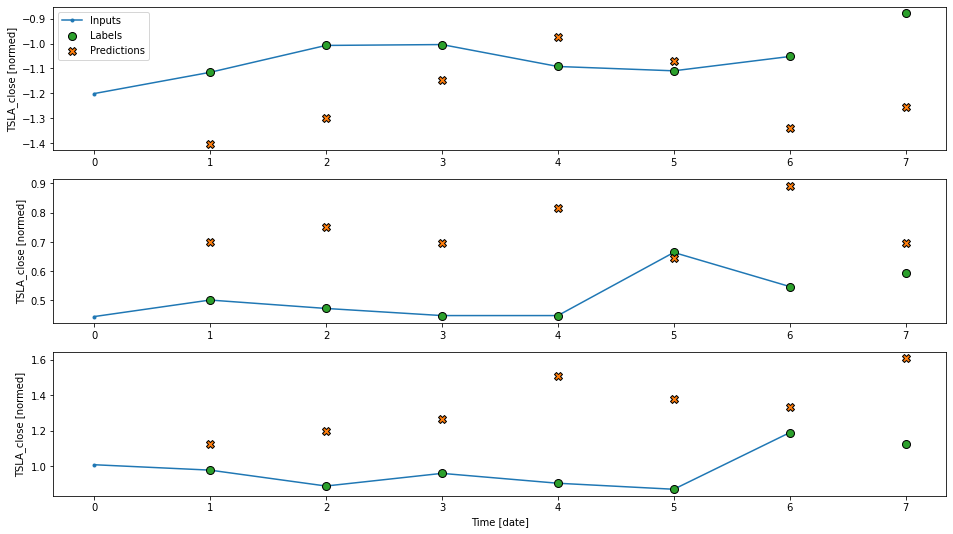

In [227]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to interpret. You can pull out the layer's weights, and see the weight assigned to each input:

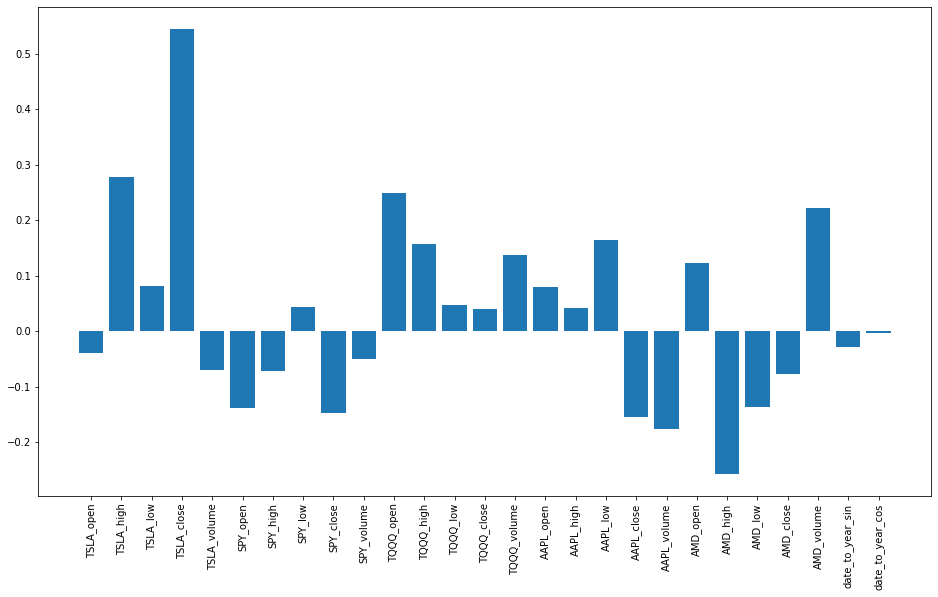

In [228]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `TSLA_close`. This is one of the risks of random initialization.

### Dense

In [229]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
28/28 [==============================] - 0s 8ms/step - loss: 0.5195 - mean_absolute_error: 0.5159 - val_loss: 2.9785 - val_mean_absolute_error: 1.2915
Epoch 2/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0647 - mean_absolute_error: 0.1936 - val_loss: 0.7411 - val_mean_absolute_error: 0.5836
Epoch 3/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0315 - mean_absolute_error: 0.1314 - val_loss: 0.5262 - val_mean_absolute_error: 0.4778
Epoch 4/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0265 - mean_absolute_error: 0.1195 - val_loss: 0.4347 - val_mean_absolute_error: 0.4296
Epoch 5/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0251 - mean_absolute_error: 0.1155 - val_loss: 0.3991 - val_mean_absolute_error: 0.4156
Epoch 6/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0240 - mean_absolute_error: 0.1118 - val_loss: 0.4978 - val_mean_absolute_error: 0.4341
Epoch 7/20
8/8 [============

#### Multi-step dense

In [230]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=label_columns)

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['TSLA_close']

Text(0.5, 1.0, 'Given 3 days as input, predict 1 day into the future.')

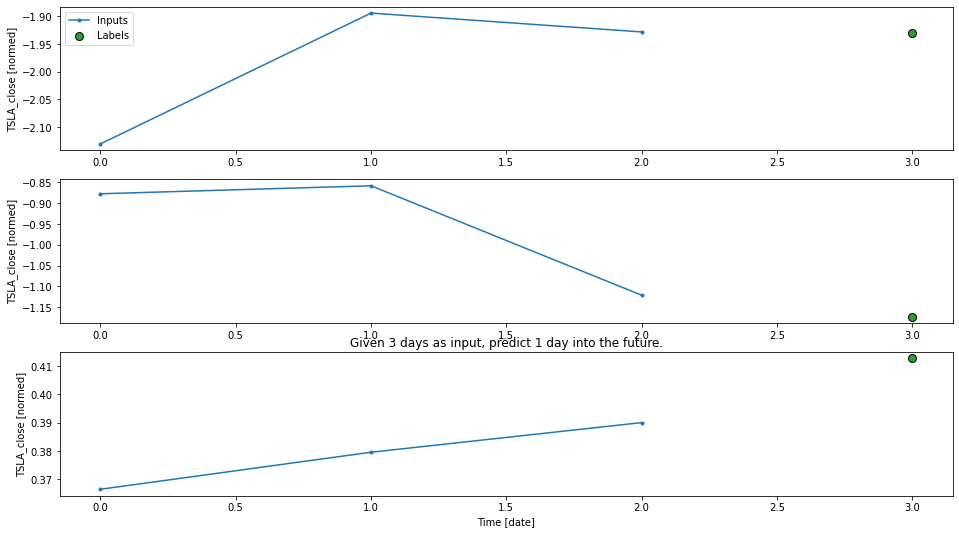

In [231]:
conv_window.plot()
plt.title("Given 3 days as input, predict 1 day into the future.")

You could train a dense model on a multiple-input-step window by adding a layers.Flatten as the first layer of the model

In [232]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [233]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 27)
Output shape: (32, 1, 1)


In [234]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

8/8 [==============================] - 0s 665us/step - loss: 1.3027 - mean_absolute_error: 0.7603


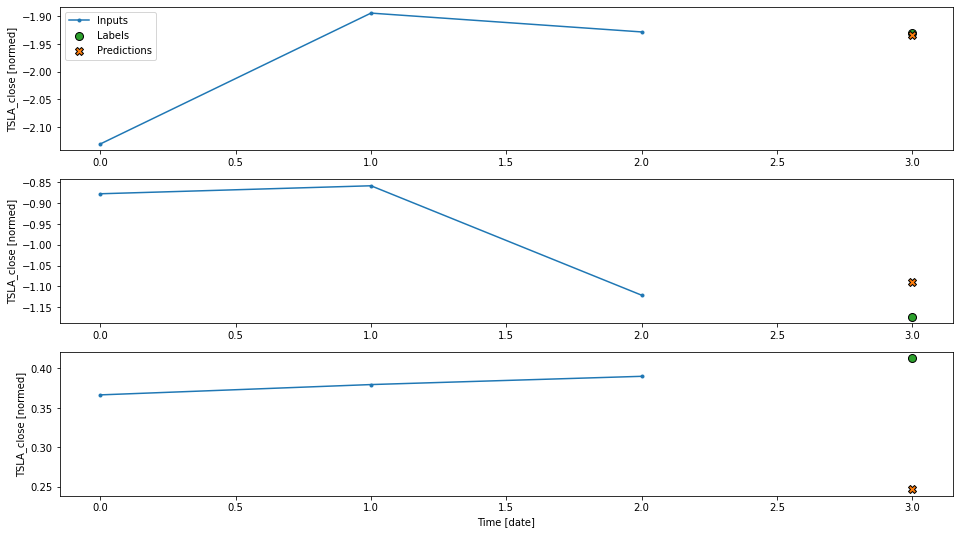

In [235]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input wndows of exactly this shape.

In [236]:
print('Input shape:', wide_window.example[0].shape)
try:
    print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 7, 27)

InvalidArgumentError:Matrix size-incompatible: In[0]: [32,189], In[1]: [81,32] [Op:MatMul]


### Convolution neural network

In [237]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [238]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 27)
Output shape: (32, 1, 1)


In [239]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

8/8 [==============================] - 0s 690us/step - loss: 0.8555 - mean_absolute_error: 0.6248


In [240]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 7, 27)
Labels shape: (32, 7, 1)
Output shape: (32, 5, 1)


In [241]:
LABEL_WIDTH = 7
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=label_columns)

wide_conv_window

Total window size: 10
Input indices: [0 1 2 3 4 5 6 7 8]
Label indices: [3 4 5 6 7 8 9]
Label column name(s): ['TSLA_close']

In [242]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 9, 27)
Labels shape: (32, 7, 1)
Output shape: (32, 7, 1)


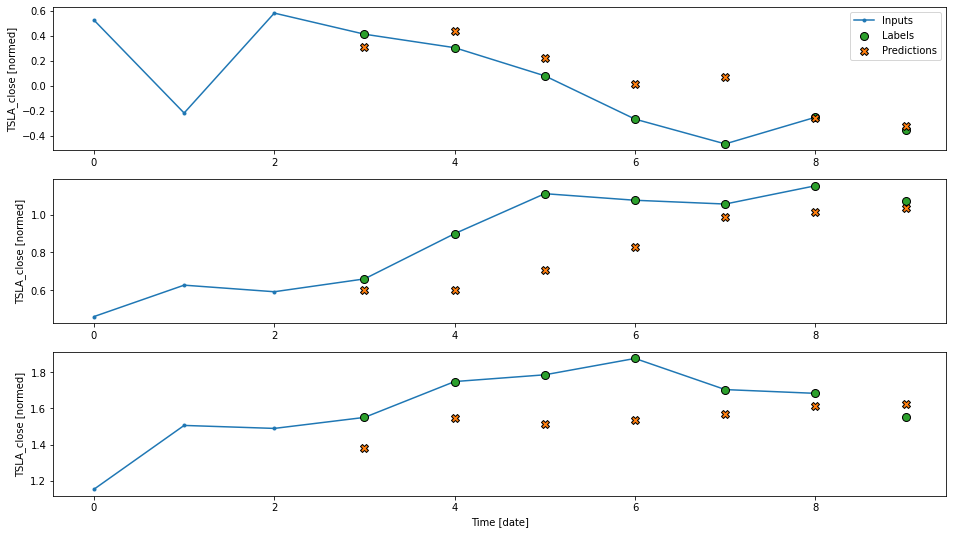

In [243]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

In [244]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [245]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 7, 27)
Output shape: (32, 7, 1)


In [246]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

8/8 [==============================] - 0s 1ms/step - loss: 4.0582 - mean_absolute_error: 1.0510


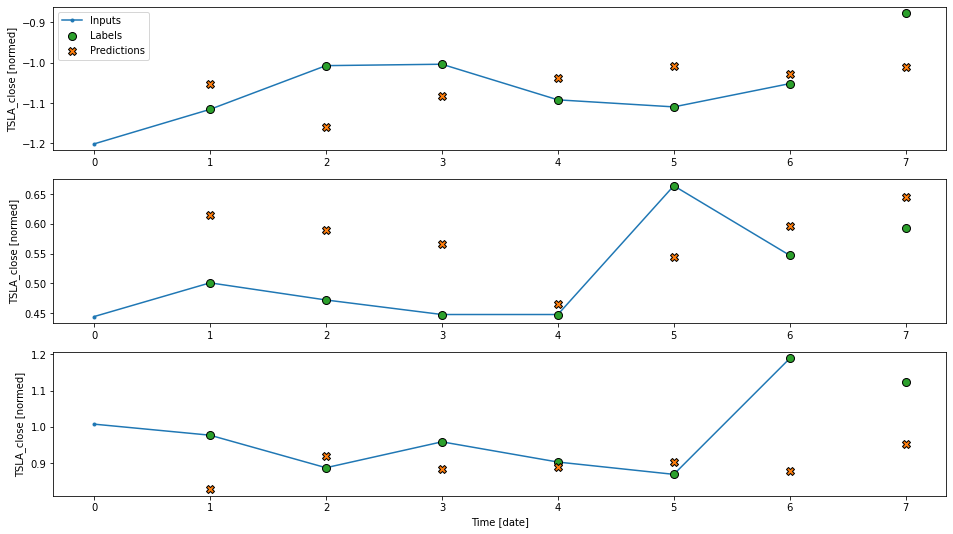

In [247]:
wide_window.plot(lstm_model)

### Performance

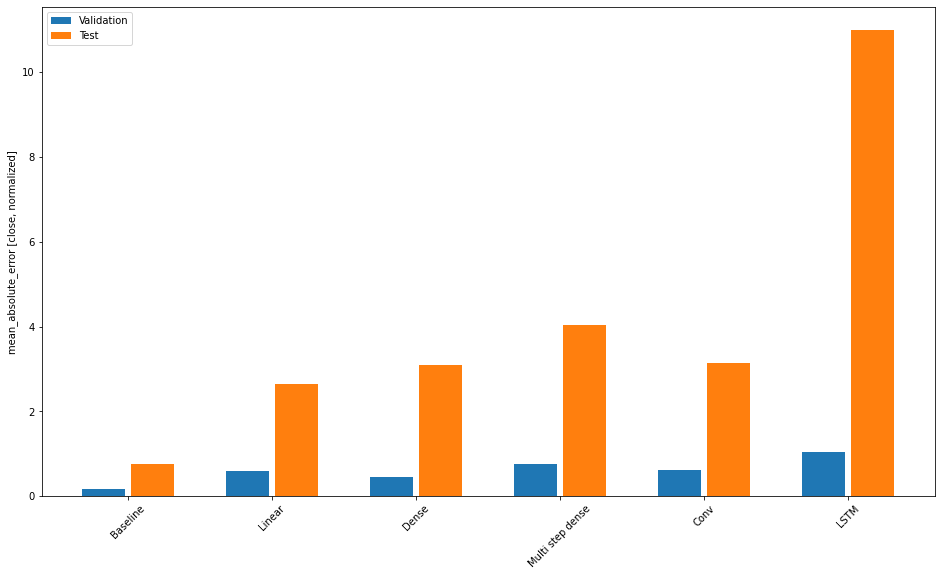

In [248]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [close, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [249]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.7712
Linear      : 2.6453
Dense       : 3.0905
Multi step dense: 4.0345
Conv        : 3.1313
LSTM        : 10.9804


### Multi Output Models

In [250]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 7, 27)
Labels shape (batch, time, features): (32, 7, 27)


In [251]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [252]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

8/8 [==============================] - 0s 618us/step - loss: 0.1761 - mean_absolute_error: 0.1846


In [253]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [254]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

8/8 [==============================] - 0s 709us/step - loss: 0.4731 - mean_absolute_error: 0.4377


In [255]:
%%time
wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

8/8 [==============================] - 0s 1ms/step - loss: 2.3096 - mean_absolute_error: 0.9247

CPU times: user 10.6 s, sys: 3.1 s, total: 13.7 s
Wall time: 6.67 s


In [256]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each timestep is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [257]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

8/8 [==============================] - 0s 1ms/step - loss: 0.1727 - mean_absolute_error: 0.1947

CPU times: user 4.96 s, sys: 1.09 s, total: 6.05 s
Wall time: 3.73 s


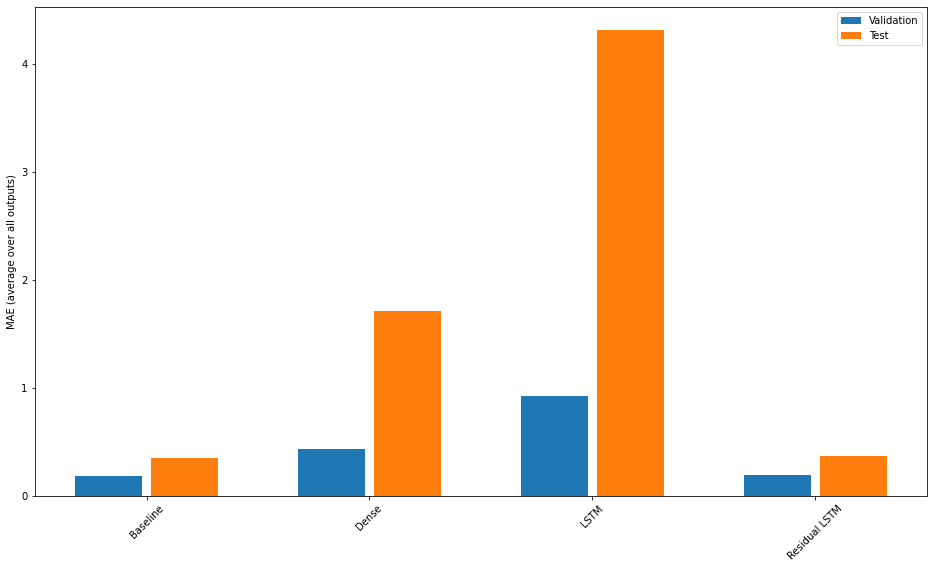

In [258]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

### Multi Step Models

Total window size: 14
Input indices: [0 1 2 3 4 5 6]
Label indices: [ 7  8  9 10 11 12 13]
Label column name(s): None

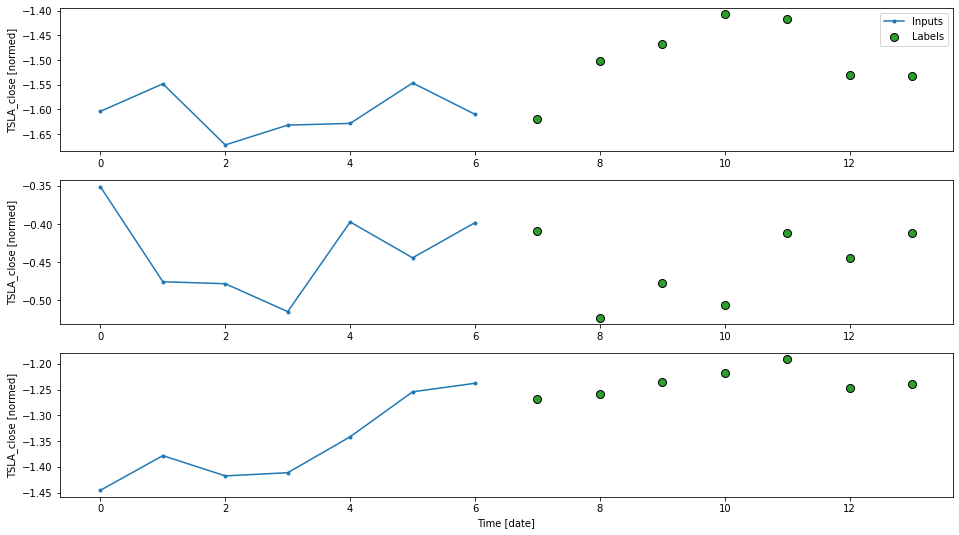

In [259]:
OUT_STEPS = 7
multi_window = WindowGenerator(input_width=7,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

8/8 [==============================] - 0s 628us/step - loss: 0.3992 - mean_absolute_error: 0.3031


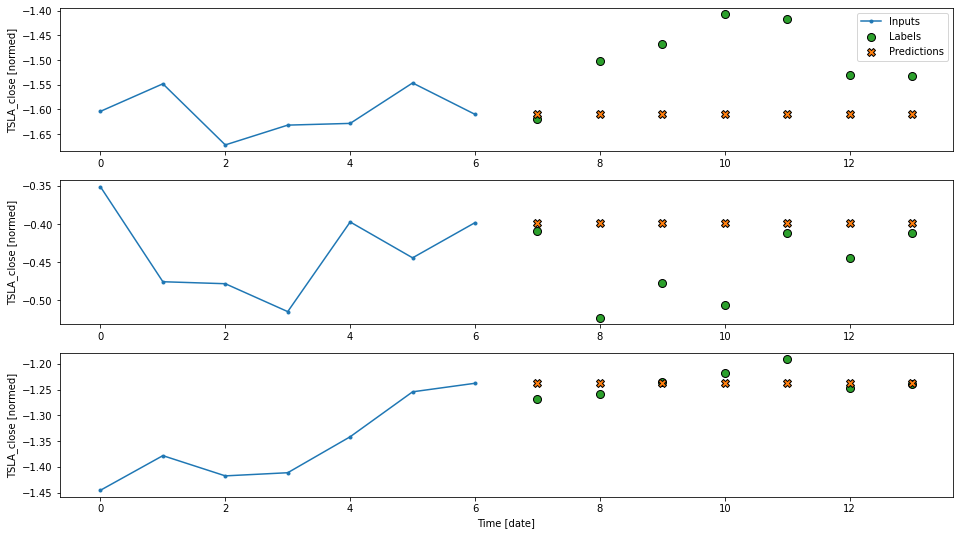

In [260]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)
multi_window.plot(last_baseline)

8/8 [==============================] - 0s 605us/step - loss: 0.5517 - mean_absolute_error: 0.3887


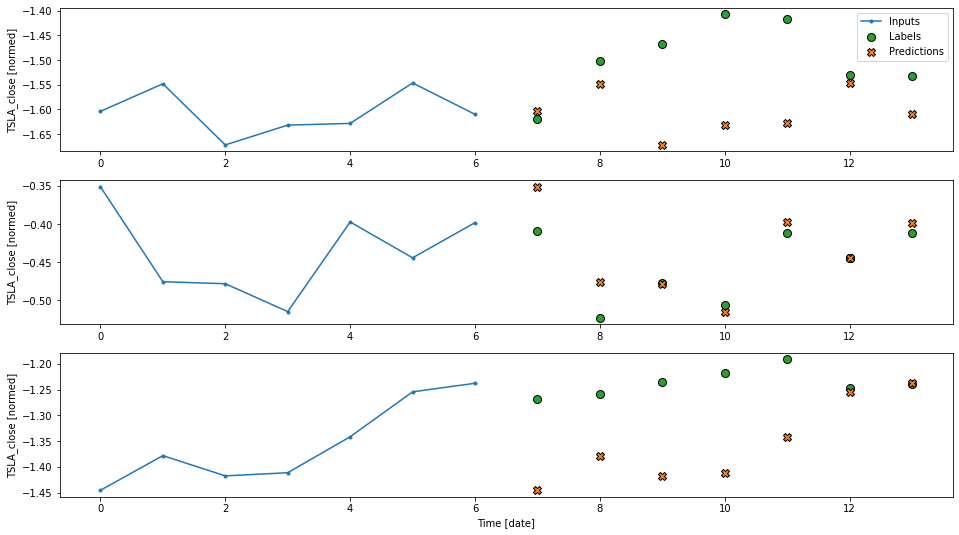

In [261]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

8/8 [==============================] - 0s 678us/step - loss: 0.6504 - mean_absolute_error: 0.5136


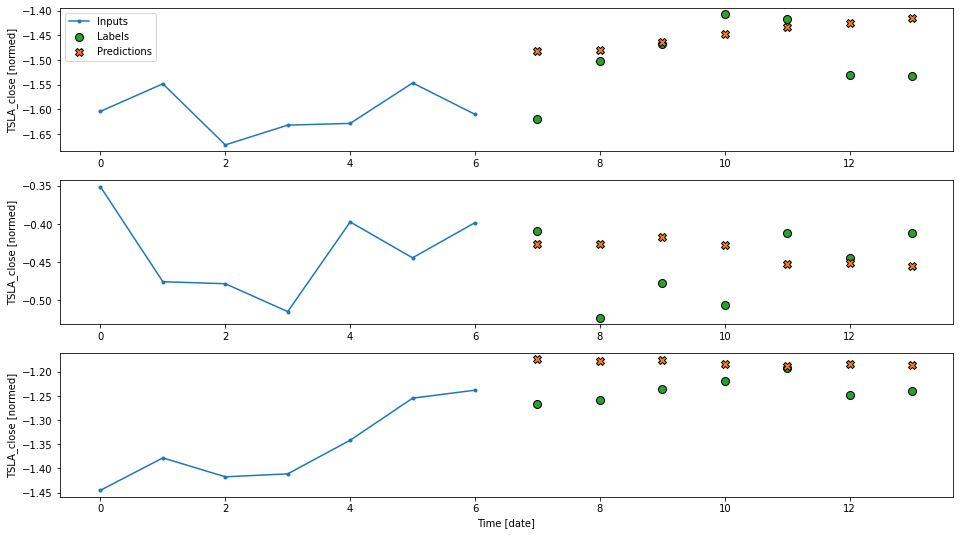

In [262]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

### Dense
Adding a layers.Dense between the input and output gives the linear model more power, but is still only based on a single input timestep.

8/8 [==============================] - 0s 857us/step - loss: 0.7159 - mean_absolute_error: 0.4968


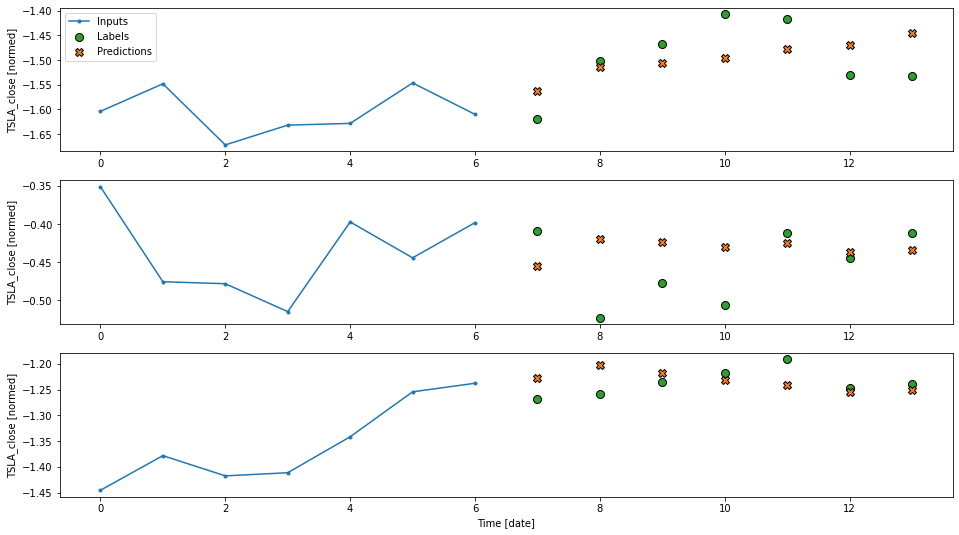

In [263]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

### CNN

8/8 [==============================] - 0s 755us/step - loss: 0.8118 - mean_absolute_error: 0.5526


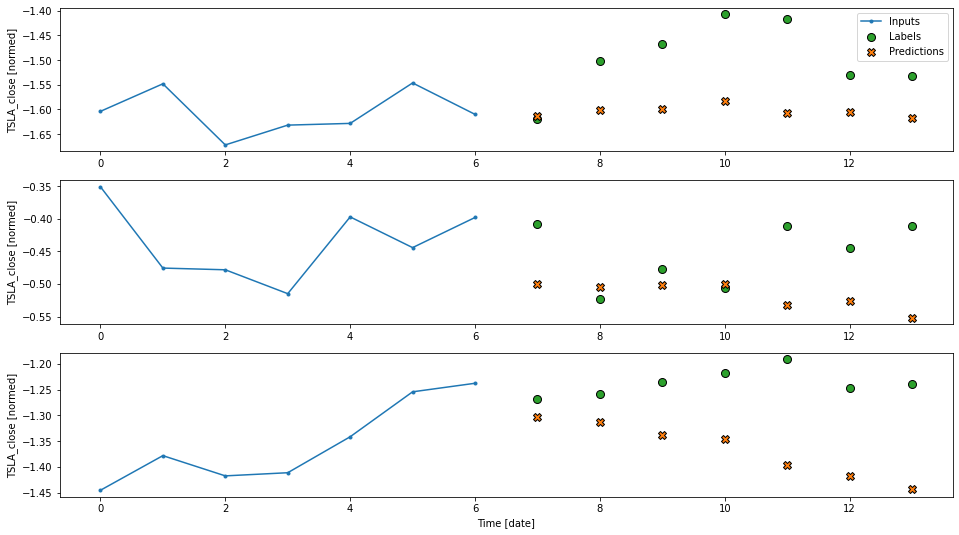

In [264]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

### RNN

8/8 [==============================] - 0s 1ms/step - loss: 2.9943 - mean_absolute_error: 1.1056


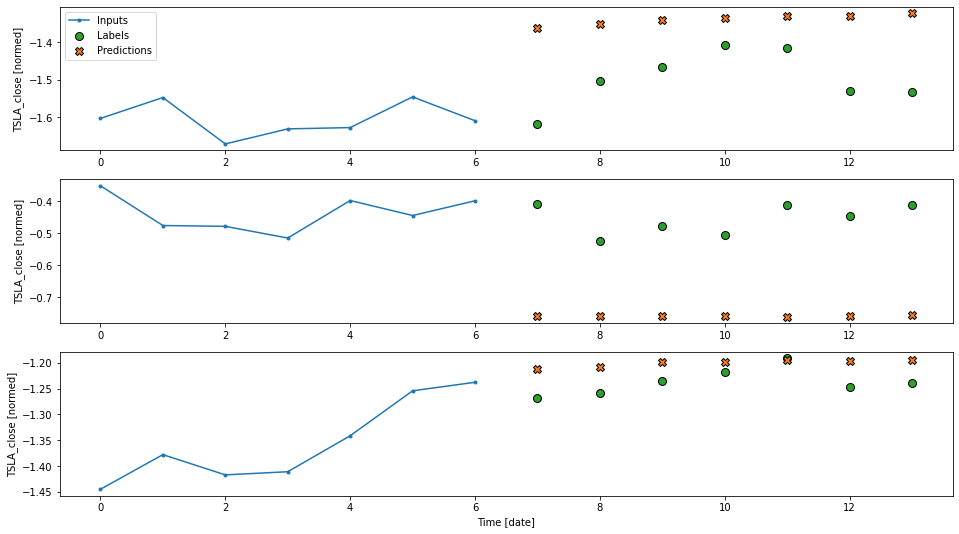

In [265]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.train, verbose=0)
multi_window.plot(multi_lstm_model)

### Advanced: Autoregressive model

#### RNN

In [266]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
   
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

In [267]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [268]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 27])

In [269]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 7, 27)


8/8 [==============================] - 0s 1ms/step - loss: 2.7340 - mean_absolute_error: 1.0506


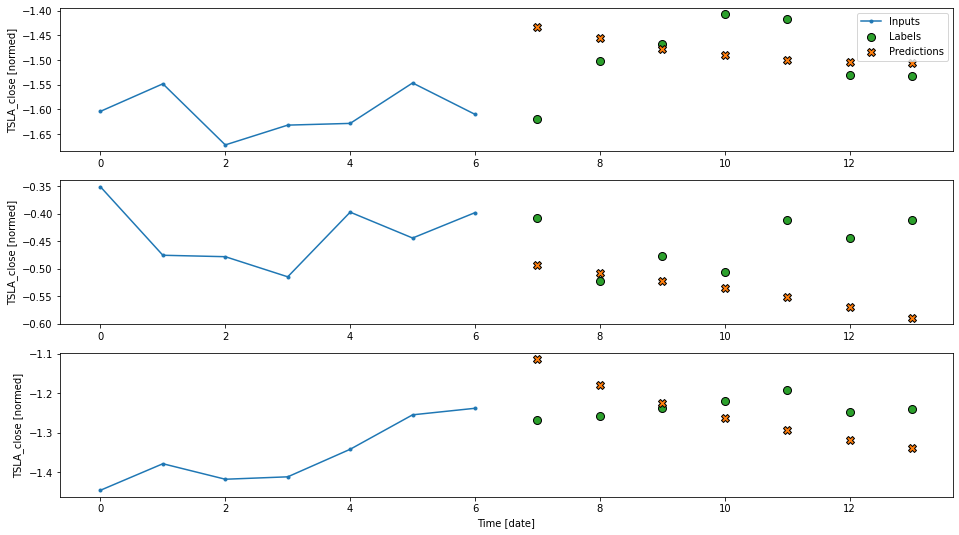

In [270]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Custom Model



8/8 [==============================] - 0s 1ms/step - loss: 2.6854 - mean_absolute_error: 1.0550


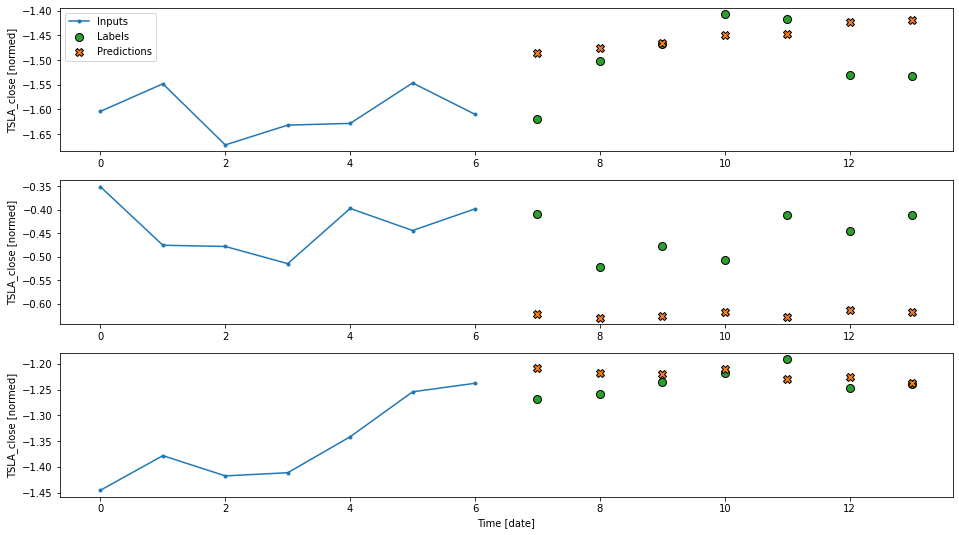

In [315]:
custom_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.AveragePooling1D(pool_size=1),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dropout(0.20),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(custom_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Custom'] = custom_model.evaluate(multi_window.val)
multi_performance['Custom'] = custom_model.evaluate(multi_window.train, verbose=0)
multi_window.plot(custom_model)

### Performance

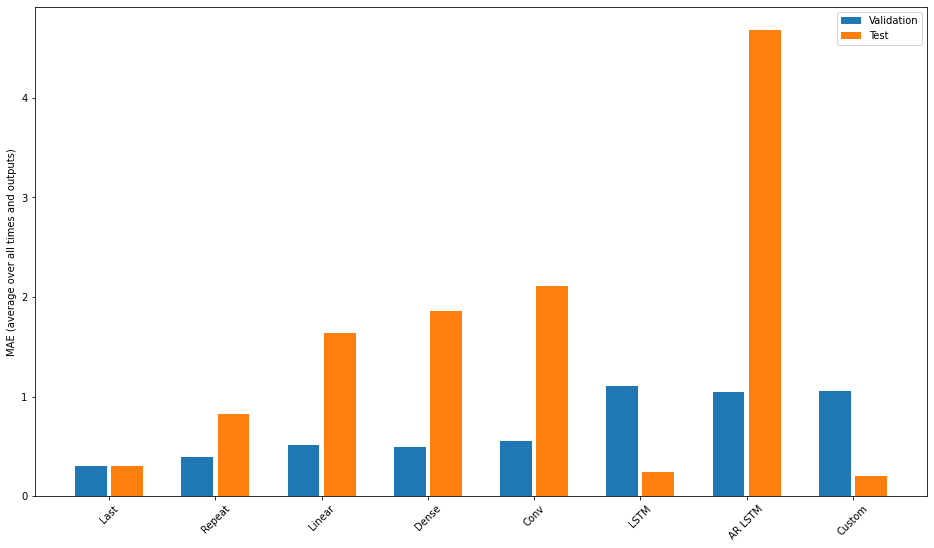

In [316]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [317]:
for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.3031
Repeat  : 0.8219
Linear  : 1.6375
Dense   : 1.8550
Conv    : 2.1062
LSTM    : 0.2415
AR LSTM : 4.6796
Custom  : 0.2009
